<a href="https://colab.research.google.com/github/michaelCastillo/LSTNet/blob/master/MRG_timeseries_exp_RRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM HH-model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/Shareddrives/ProjectoTesis/Data/results_21_06.zip > /dev/null
!cd drive


Mounted at /content/drive


**Note:** This notebook can run using TensorFlow 2.5.0

In [3]:
#To be used in case of new environment
#!pip install tensorflow==2.5.0
#!pip install pandas
!pip install neuron
%cd "/content/drive/Shareddrives/ProjectoTesis/Code/Tesis_rrnn_neurosiml/src"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[Errno 2] No such file or directory: '/content/drive/Shareddrives/ProjectoTesis/Code/Tesis_rrnn_neurosiml/src'
/content


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
from pandas import read_csv
import time
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import pandas as pd
import seaborn as sns

2.8.2


In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df


    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}


    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    self.completeLabels = labels #to save all the information but splitted.
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
  
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    print(len(data))
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    print(len(list(ds)))
    print(len(list(ds))*128)
    ds = ds.map(self.split_window)
    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)


  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result



  def plot(self, model=None, plot_col='vm', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    stimuliIndex = self.column_indices["stimuli_vm"]
    max_n = min(max_subplots, len(inputs))
    print(max_n)
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10, color="#d62728")
      plt.plot(self.input_indices, inputs[n, :, stimuliIndex]*200-80,
              label='Inputs', marker='.', zorder=-10, color="#1f77b4")
      
      
      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  marker=".", label='Labels', c='#2ca02c', s=8)
      # plt.scatter(self.label_indices, labels[n, :, stimuliIndex],
      #             edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker=".", label='Predictions',
                    c='#ff7f0e', s=8)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')
    



MAX_EPOCHS = 20
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Window generator

## Generating series


2022-07-03 20:00:35,771 | INFO | Generating amp: 0.4,
                         freq: 0.4,
                         delay:10,
                         t_siml:100.0,
                         type_siml:monophasic_pulse_train,
                         scale:9999
          


,t,vm,stimuli_vm
0,0.00,-77.300000,0.0
1,0.01,-77.319968,0.0
2,0.02,-77.336411,0.0
3,0.03,-77.351126,0.0
4,0.04,-77.364656,0.0


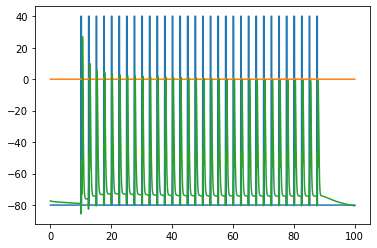

In [ ]:
from utils.files import getFilenames, getValues
from utils.lstm_utils import combineTimeSeries, generateStimulationSignal, rescale,scale_stimTo_simulation, index_trim_simulation
def plot_series(time, series, format="-",figure = 1, title="", start=0, end=None):
    plt.figure(figure)
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    plt.grid(True)

filename="results/voltage/monophasic_pulse_train/voltage_amp_0.4_freq_0.4_fiberd_10_dist_100_tsiml_100_pw_0.2_step_0.01.csv"
simulation_df = read_csv(filename)
simulationVm = simulation_df.values 
values = getValues(filename)
simulationTime = float(values["tsiml"])
v_scaled, t_scaled = scale_stimTo_simulation(float(values["amp"]), float(values["freq"]), 10 , simulationTime, values["type_stimuli"], len(simulationVm))
series_size = t_scaled.size
trainingSetProp = 0.6
simulation_df["stimuli_vm"] = v_scaled
simulationVm = simulation_df[["stimuli_vm", "vm"]].to_numpy()
split_time = int(trainingSetProp*series_size)
time_train = t_scaled[:split_time]
x_train = simulationVm[:split_time]
time_valid = t_scaled[split_time:]
x_valid = simulationVm[split_time:]

# simulation_df = simulation_df[0::20]
v_scaled = v_scaled *300 -80
plt.figure(1)
plt.plot(t_scaled, v_scaled)
plt.plot(t_scaled, simulationVm)
# plt.margins(x=-0.3, y=0)

# print(f"time_train_size: {time_train.size} ~ x_tran_size: {x_train.size} ~  time_valid_s: {time_valid.size} ~ x_valid: {x_valid.size}")

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
simulation_df.head()

=== Description ===
             count       mean        std        min        25%        50%  \
t           9999.0  49.990000  28.866070   0.000000  24.995000  49.990000   
vm          9999.0 -65.607292  18.867867 -85.617714 -74.452862 -73.634023   
stimuli_vm  9999.0   0.024962   0.096762   0.000000   0.000000   0.000000   

                  75%        max  
t           74.985000  99.980000  
vm         -64.713268  26.936275  
stimuli_vm   0.000000   0.400000  
N:  9999
Num features:  2

=== Window ===


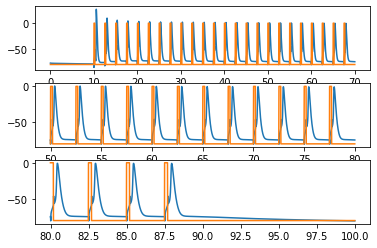

In [ ]:

simulation_df.head()
print("=== Description ===")
print(simulation_df.describe().transpose())
df = simulation_df
column_indices = {name: i for i, name in enumerate(df.columns)}
fig, axs = plt.subplots(3)
date_time = df.pop('t')
n = len(df)
print("N: ",n)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.5):int(n*0.8)]
test_df = df[int(n*0.8):]
num_features = df.shape[1]

axs[0].plot(date_time[0:int(n*0.7)], train_df['vm'])
axs[0].plot(date_time[0:int(n*0.7)], train_df['stimuli_vm']*200-80)
axs[1].plot(date_time[int(n*0.5):int(n*0.8)], val_df['vm'])
axs[1].plot(date_time[int(n*0.5):int(n*0.8)], val_df['stimuli_vm']*200-80)
axs[2].plot(date_time[int(n*0.8):], test_df['vm'])
axs[2].plot(date_time[int(n*0.8):], test_df['stimuli_vm']*200-80)

print("Num features: ",num_features)
print("\n=== Window ===")

## Baseline

3000
94
12032
94/94 [==============================] - 2s 7ms/step - loss: 4317.3267 - mean_absolute_error: 62.7937
2000
63
8064
6999
218
27904
Input shape: (32, 24, 2)
Output shape: (32, 24, 1)
3


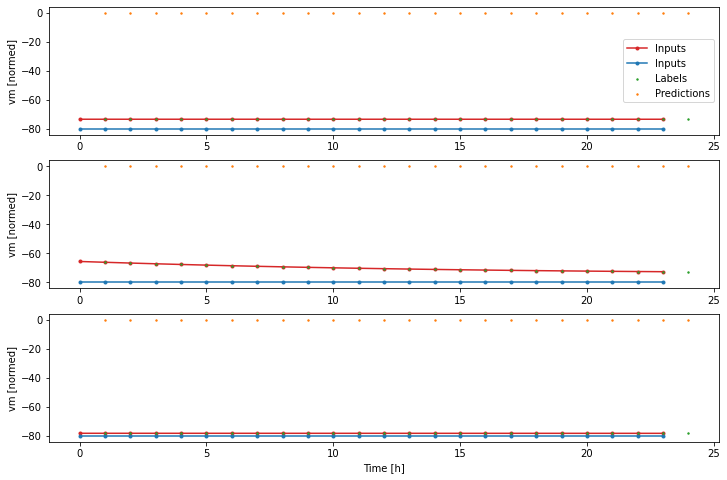

In [ ]:
single_step_window = WindowGenerator(train_df=train_df,val_df=val_df,test_df=test_df,input_width=1, label_width=1, shift=1,
                     label_columns=['vm'])
single_step_window

class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

baseline = Baseline(label_index=column_indices['vm'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

wide_window = WindowGenerator(train_df=train_df,val_df=val_df,test_df=test_df,
    input_width=24, label_width=24, shift=1,
    label_columns=['vm'])

wide_window

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


wide_window.plot(baseline)

## Multi-step Dense


6999
191
24448
4


Text(0.5, 1.0, 'Given 500 steps of inputs, predict 400 steps into the future.')

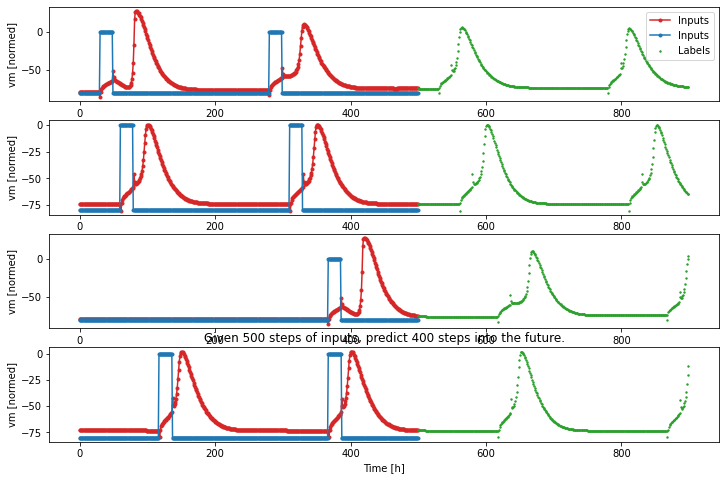

In [ ]:
CONV_WIDTH = 500
label_width= 400
SHIFT = 400
conv_window = WindowGenerator(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    input_width=CONV_WIDTH,
    label_width=label_width,
    shift=SHIFT,
    label_columns=['vm'])
conv_window
conv_window.plot(max_subplots=4)
plt.title(f"Given {CONV_WIDTH} steps of inputs, predict {label_width} steps into the future.")


In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

history = compile_and_fit(conv_model, conv_window)
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)



3000
66
8448
66/66 [==============================] - 0s 5ms/step - loss: 369.3967 - mean_absolute_error: 14.9891
2000
35
4480


## Multistep only with convolutions

6999
185
23680
3


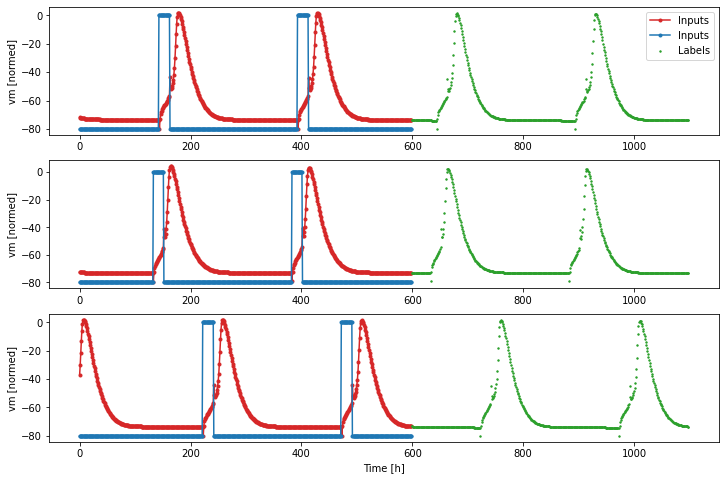

In [ ]:



#plt.title(f"Given {CONV_WIDTH} steps of inputs, predict {label_width} steps into the future.")

LABEL_WIDTH = 500
CONV_WIDTH = 100
# Hasta el ultimo valor hasta antes de la convolucion.
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=500,
    label_columns=['vm'])

wide_conv_window.plot()

##Prediction

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
print("Conv model on `conv_window`")
print('Input shape:', wide_conv_window.example[0].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)



history = compile_and_fit(conv_model, wide_conv_window)
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(wide_conv_window.val)
performance['Conv'] = conv_model.evaluate(wide_conv_window.test, verbose=0)

print("Wide conv window")

print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)


3000
60
7680
60/60 [==============================] - 0s 5ms/step - loss: 11.4127 - mean_absolute_error: 2.2020
2000
29
3712
Wide conv window
Labels shape: (32, 500, 1)
Output shape: (32, 500, 1)


Wide conv window
6999
185
23680
Input shape: <MapDataset element_spec=(TensorSpec(shape=(None, 599, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 500, 1), dtype=tf.float32, name=None))>
Labels shape: (32, 500, 1)
Output shape: (32, 500, 1)
25


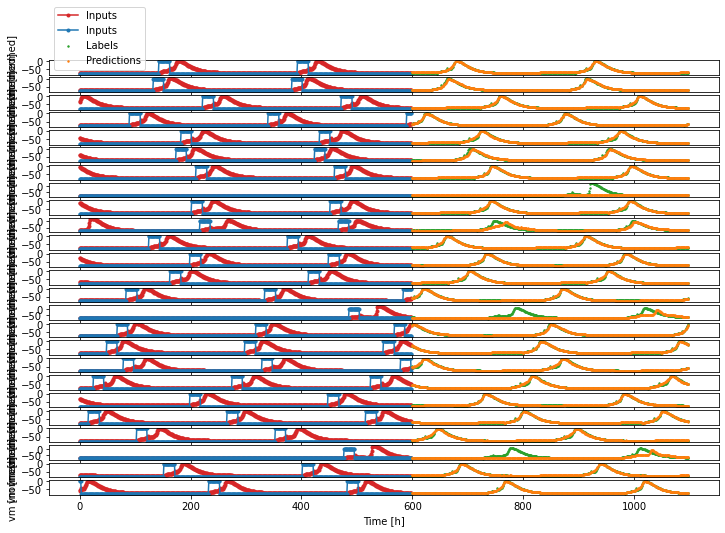

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.train)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

train_df = wide_conv_window.train_df



wide_conv_window.plot(conv_model, max_subplots=25)

## Complete simulation

In [ ]:
def simulate(self, model):
    # trainIterator = iter(self.train)
    # max_n = 15
    # plot_col = "vm"
    # plot_col_index = self.column_indices[plot_col]
    # for n in range(max_n):
    #   inputs, labels = next(trainIterator)
    #   plt.subplot(max_n, 1, n+1)
    #   plt.ylabel(f'{plot_col} [normed]')
    #   plt.plot(self.input_indices, inputs[n, :, plot_col_index],
    #           label='Inputs', marker='.', zorder=-10)

    predictSize=599
    # predictStart = predictSize*0
    # predictSlice = slice(predictStart,predictStart + predictSize)
    # print(self.train_df[predictSlice])
    # input = self.train_df[predictSlice]
    # ds = tf.keras.utils.timeseries_dataset_from_array(
    #     data=input,
    #     targets=None,
    #     sequence_length=predictSize,
    #     sequence_stride=1,
    #     shuffle=False,
    #     batch_size=32,)
    # print(self.total_window_size)
    # print(len(list(ds)))
    
    # inputs = ds.map(self.minisplit)
    # sampleInput = next(iter(inputs))
    # # print(sampleInput)
    # predictions = model(sampleInput)
    ## PLOT
    # plot_col="vm"
    # label_col_index = self.label_columns_indices.get(plot_col, None)
    # stimuliIndex = self.column_indices["stimuli_vm"]
    # # print("Size prediction: ",len(predictions[0, :, label_col_index]))
    # plt.plot(self.input_indices, sampleInput[0, :, plot_col_index],
    #           label='Inputs', marker='.', zorder=-10)
    # plt.plot(self.input_indices, sampleInput[0, :, stimuliIndex]*200-80,
    #         label='Inputs', marker='.', zorder=-10)
    # plt.scatter(self.label_indices, predictions[0, :, label_col_index],
    #             marker='X', edgecolors='k', label='Predictions',
    #             c='#ff7f0e', s=64)
    # numpyTensor = predictions.numpy()[0,:,0]
    predictStart = 2000
    predictions = []
    simulation = np.array([])
    for i in range(int(df.size/predictSize)-4):
      predictEnd = predictStart + predictSize
      predictSlice = slice(predictStart,predictEnd)
      labelWidth = label_width
      historySize= predictSize - labelWidth
      print(f"start: {predictStart},  predictEnd: {predictStart + predictSize}")
      if(i == 0):
        input = df[predictSlice]
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=input,
            targets=None,
            sequence_length=predictSize,
            sequence_stride=1,
            shuffle=False,
            batch_size=32,)
        print(self.total_window_size)
        print(len(list(ds)))
        
        inputs = ds.map(self.minisplit)
        sampleInput = next(iter(inputs))
        print(sampleInput)
        predictions = model(sampleInput)
      else:
        
        numpyTensor = predictions.numpy()[0,:,0]
        print(numpyTensor)
        print(inputs)
        #df.loc[historySize:predictSize-1,"vm"] = numpyTensor
        inputs = df[predictSlice]
        print("size: ",inputs)
      predictStart += labelWidth
      simulation = np.append(simulation, predictions.numpy()[0,:,0])
      stimuliSignal = df[slice(2000,2000+len(simulation))]
      print(stimuliSignal.size)
      print(simulation.size)
      plt.plot(simulation)
      plt.plot(stimuliSignal["vm"])
      #plt.plot(stimuliSignal["stimuli_vm"])
def minisplit(self, features):
    inputs = features[:, self.input_slice, :]
    inputs.set_shape([None, self.input_width, None])
    return inputs


WindowGenerator.minisplit = minisplit
WindowGenerator.simulate = simulate

start: 2000,  predictEnd: 2599
1099
1
tf.Tensor(
[[[-73.0706787    0.        ]
  [-79.13867145   0.4       ]
  [-72.20273951   0.4       ]
  ...
  [-69.6592545    0.        ]
  [-69.89964894   0.        ]
  [-70.12473556   0.        ]]], shape=(1, 599, 2), dtype=float64)
1000
500
start: 2400,  predictEnd: 2999
[-70.743454  -70.945496  -71.27282   -71.01837   -71.02393   -71.12176
 -71.62966   -71.989365  -72.12212   -72.56616   -72.6663    -72.508286
 -72.56682   -72.38494   -72.34352   -72.15724   -72.533676  -72.607635
 -72.80366   -72.380104  -72.521515  -72.32215   -72.2137    -72.2155
 -72.38514   -72.6125    -72.82039   -72.9783    -73.08238   -73.13252
 -73.15273   -73.13906   -73.152016  -73.18991   -73.22051   -73.242256
 -73.26213   -73.28221   -73.299515  -73.314415  -73.32659   -73.33706
 -73.34597   -73.35326   -73.35917   -73.36395   -73.36783   -73.37095
 -73.37344   -73.37544   -73.37703   -73.37828   -73.37928   -73.38005
 -73.38066   -73.43576   -73.530174  -73.620834

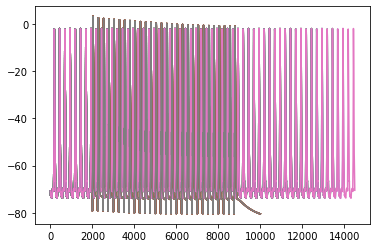

In [ ]:
wide_conv_window.simulate(conv_model)

# Old implementatios


## Multistep with LSTM

6999
200
25600
3


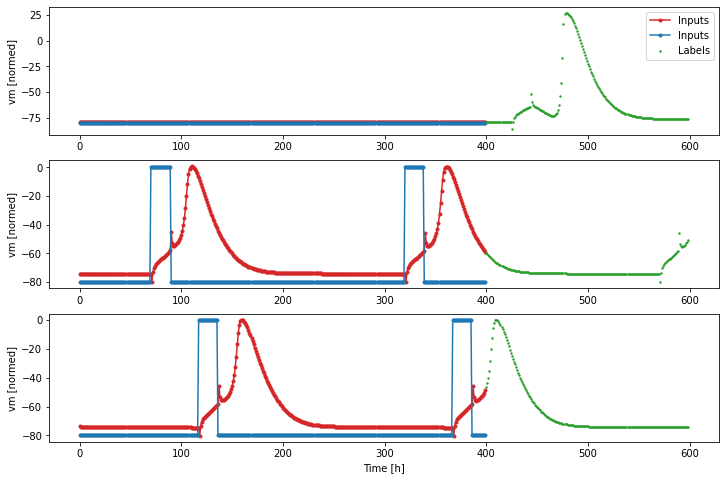

In [ ]:
wide_lstm_window = WindowGenerator(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    input_width=400, 
    label_width=200, 
    shift=200,
    label_columns=['vm'])

wide_lstm_window.plot()
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_lstm_window.example[0].shape)
print('Output shape:', lstm_model(wide_lstm_window.example[0]).shape)

Input shape: (32, 400, 2)
Output shape: (32, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_lstm_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_lstm_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_lstm_window.test, verbose=0)


3000
76
9728
76/76 [==============================] - 1s 9ms/step - loss: 376.5506 - mean_absolute_error: 14.1501
2000
44
5632


In [1]:
wide_lstm_window.plot(lstm_model)

NameError: ignored

## Old LSTM.

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

In [ ]:
# Plotting the simulation scaled
plot_series(t_scaled, v_scaled, title="Stimulation serie", figure=1)
plot_series(t_scaled, simulationVm, title="Simulation response serie", figure=2)

## First attempt: LSTM univariate.
- Epochs: 100.
- window_size = 30.
- Using a fixed learning rate.
- Gradient descend.

In [ ]:
start_time = time.time()
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 2]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
one_hundred_epochs_trainingtime_taken = time.time()-start_time

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 50])

In [ ]:
import time
start = time.time()
rnn_forecast = model_forecast(model, simulationVm[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
total= time.time() - start
print(f"series size: {simulationVm.size}")
print(f"Time elapsed: {total}s")
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid[:,-1])
plot_series(time_valid, rnn_forecast)

In [ ]:
start_time = time.time()
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="softmax",
                      input_shape=[None, 2]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)
five_hundred_epochs_trainingtime_taken = time.time()-start_time

In [ ]:
import time
start = time.time()
rnn_forecast = model_forecast(model, simulationVm[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
total= time.time() - start
print(f"series size: {simulationVm.size}")
print(f"Time elapsed: {total}s")
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid[:,-1])
plot_series(time_valid, rnn_forecast)
print(f"valid: ",x_valid[0:100])
print(f"forecast: ", rnn_forecast[0:100])
# Será que la convolución qye hace al principio pordría disminuir el tamaño de mis samplings ?

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()